In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = False
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

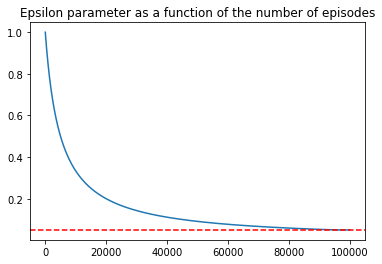

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 1*10**5
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 18

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+f"{simulation_id}") 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minutes.")        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode_retrain}")
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    
    

Episode: 100. Elapsed time  0.06  minuts. epsilon 0.9806 Discounted reward:  -19.650117430563533
Episode: 200. Elapsed time  0.13  minuts. epsilon 0.9617 Discounted reward:  -16.834729291768042
Episode: 300. Elapsed time  0.21  minuts. epsilon 0.9436 Discounted reward:  -18.499655083201628
Episode: 400. Elapsed time  0.29  minuts. epsilon 0.9261 Discounted reward:  -15.286413772806133
Episode: 500. Elapsed time  0.39  minuts. epsilon 0.9093 Discounted reward:  -18.11675062966588
Episode: 600. Elapsed time  0.48  minuts. epsilon 0.893 Discounted reward:  -20.785461902295268
Episode: 700. Elapsed time  0.59  minuts. epsilon 0.8773 Discounted reward:  -16.77565477256132
Episode: 800. Elapsed time  0.73  minuts. epsilon 0.8622 Discounted reward:  -18.829731416718676
Episode: 900. Elapsed time  0.88  minuts. epsilon 0.8476 Discounted reward:  -15.726074452713934
Episode: 1000. Elapsed time  1.01  minuts. epsilon 0.8335 Discounted reward:  -16.253167357446063
Episode: 1100. Elapsed time  1.1

Episode: 8500. Elapsed time  21.48  minuts. epsilon 0.3704 Discounted reward:  -6.52977958749331
Episode: 8600. Elapsed time  21.95  minuts. epsilon 0.3677 Discounted reward:  -5.922217050553597
Episode: 8700. Elapsed time  22.3  minuts. epsilon 0.365 Discounted reward:  -2.5978128232546744
Episode: 8800. Elapsed time  22.63  minuts. epsilon 0.3623 Discounted reward:  -6.313405508618662
Episode: 8900. Elapsed time  23.0  minuts. epsilon 0.3597 Discounted reward:  -6.711995570592433
Episode: 9000. Elapsed time  23.34  minuts. epsilon 0.3572 Discounted reward:  -11.629328327097262
Episode: 9100. Elapsed time  23.67  minuts. epsilon 0.3546 Discounted reward:  -10.188569840286275
Episode: 9200. Elapsed time  24.08  minuts. epsilon 0.3521 Discounted reward:  -5.640581117363214
Episode: 9300. Elapsed time  24.45  minuts. epsilon 0.3497 Discounted reward:  -11.254517308228493
Episode: 9400. Elapsed time  24.79  minuts. epsilon 0.3472 Discounted reward:  -7.442304983826876
Episode: 9500. Elaps

Episode: 16800. Elapsed time  53.22  minuts. epsilon 0.2294 Discounted reward:  -2.312668040162767
Episode: 16900. Elapsed time  53.61  minuts. epsilon 0.2283 Discounted reward:  -4.546259503170989
Episode: 17000. Elapsed time  54.0  minuts. epsilon 0.2273 Discounted reward:  -2.465542075785628
Episode: 17100. Elapsed time  54.37  minuts. epsilon 0.2263 Discounted reward:  -6.627801099104355
Episode: 17200. Elapsed time  54.79  minuts. epsilon 0.2252 Discounted reward:  -3.793719804775569
Episode: 17300. Elapsed time  55.21  minuts. epsilon 0.2242 Discounted reward:  -3.6662678432803513
Episode: 17400. Elapsed time  55.65  minuts. epsilon 0.2232 Discounted reward:  -7.704778340998661
Episode: 17500. Elapsed time  56.13  minuts. epsilon 0.2222 Discounted reward:  -4.274148875123084
Episode: 17600. Elapsed time  56.61  minuts. epsilon 0.2212 Discounted reward:  -1.9587961223257073
Episode: 17700. Elapsed time  57.04  minuts. epsilon 0.2203 Discounted reward:  -7.602753610363296
Episode: 

Episode: 25100. Elapsed time  88.29  minuts. epsilon 0.1661 Discounted reward:  -1.964226837782497
Episode: 25200. Elapsed time  88.69  minuts. epsilon 0.1656 Discounted reward:  -4.786619009048669
Episode: 25300. Elapsed time  89.1  minuts. epsilon 0.165 Discounted reward:  -1.9863465471085064
Episode: 25400. Elapsed time  89.54  minuts. epsilon 0.1645 Discounted reward:  -2.226838537995744
Episode: 25500. Elapsed time  89.95  minuts. epsilon 0.1639 Discounted reward:  -3.2560723962000555
Episode: 25600. Elapsed time  90.46  minuts. epsilon 0.1634 Discounted reward:  -3.7087914177028782
Episode: 25700. Elapsed time  90.89  minuts. epsilon 0.1629 Discounted reward:  -3.895727863834675
Episode: 25800. Elapsed time  91.29  minuts. epsilon 0.1623 Discounted reward:  -3.068282954696577
Episode: 25900. Elapsed time  91.71  minuts. epsilon 0.1618 Discounted reward:  -2.2130150699072835
Episode: 26000. Elapsed time  92.13  minuts. epsilon 0.1613 Discounted reward:  -3.8303314683295233
Episode

Episode: 33300. Elapsed time  124.92  minuts. epsilon 0.1306 Discounted reward:  -2.45593374449697
Episode: 33400. Elapsed time  125.33  minuts. epsilon 0.1302 Discounted reward:  -1.4842184491119783
Episode: 33500. Elapsed time  125.8  minuts. epsilon 0.1299 Discounted reward:  -5.234548548731173
Episode: 33600. Elapsed time  126.24  minuts. epsilon 0.1295 Discounted reward:  -1.775962358864991
Episode: 33700. Elapsed time  126.66  minuts. epsilon 0.1292 Discounted reward:  -2.955546607504435
Episode: 33800. Elapsed time  127.1  minuts. epsilon 0.1289 Discounted reward:  -3.376893142596548
Episode: 33900. Elapsed time  127.52  minuts. epsilon 0.1285 Discounted reward:  -1.551713525201293
Episode: 34000. Elapsed time  127.95  minuts. epsilon 0.1282 Discounted reward:  -2.2342344223712867
Episode: 34100. Elapsed time  128.41  minuts. epsilon 0.1279 Discounted reward:  -0.8870523719662919
Episode: 34200. Elapsed time  128.83  minuts. epsilon 0.1276 Discounted reward:  -1.0278231908824764

Episode: 41500. Elapsed time  162.74  minuts. epsilon 0.1075 Discounted reward:  -1.008211349832732
Episode: 41600. Elapsed time  163.16  minuts. epsilon 0.1073 Discounted reward:  -2.7450640813075533
Episode: 41700. Elapsed time  163.6  minuts. epsilon 0.1071 Discounted reward:  -6.93997419027727
Episode: 41800. Elapsed time  164.14  minuts. epsilon 0.1068 Discounted reward:  -2.291418419227978
Episode: 41900. Elapsed time  164.6  minuts. epsilon 0.1066 Discounted reward:  -2.9534026352084757
Episode: 42000. Elapsed time  165.04  minuts. epsilon 0.1064 Discounted reward:  -2.6042565736343426
Episode: 42100. Elapsed time  165.46  minuts. epsilon 0.1062 Discounted reward:  -1.2015606138360537
Episode: 42200. Elapsed time  165.95  minuts. epsilon 0.1059 Discounted reward:  -4.664988826102093
Episode: 42300. Elapsed time  166.51  minuts. epsilon 0.1057 Discounted reward:  -1.1670902444464053
Episode: 42400. Elapsed time  166.95  minuts. epsilon 0.1055 Discounted reward:  -3.71298586705826

Episode: 49700. Elapsed time  200.53  minuts. epsilon 0.0914 Discounted reward:  -0.8536844000275312
Episode: 49800. Elapsed time  200.96  minuts. epsilon 0.0912 Discounted reward:  -0.8339477867748433
Episode: 49900. Elapsed time  201.39  minuts. epsilon 0.0911 Discounted reward:  -2.7833847536379555
Episode: 50000. Elapsed time  201.82  minuts. epsilon 0.0909 Discounted reward:  -0.7842907722534568
Episode: 50100. Elapsed time  202.26  minuts. epsilon 0.0907 Discounted reward:  -6.94850551795557
Episode: 50200. Elapsed time  202.7  minuts. epsilon 0.0906 Discounted reward:  -0.9370981244735905
Episode: 50300. Elapsed time  203.21  minuts. epsilon 0.0904 Discounted reward:  -5.120812954977515
Episode: 50400. Elapsed time  203.64  minuts. epsilon 0.0903 Discounted reward:  -2.7644717580535687
Episode: 50500. Elapsed time  204.07  minuts. epsilon 0.0901 Discounted reward:  -2.085968225412451
Episode: 50600. Elapsed time  204.53  minuts. epsilon 0.0899 Discounted reward:  -3.187817322800

Episode: 57900. Elapsed time  239.0  minuts. epsilon 0.0795 Discounted reward:  -1.627903736301712
Episode: 58000. Elapsed time  239.44  minuts. epsilon 0.0794 Discounted reward:  -2.980858380075172
Episode: 58100. Elapsed time  239.94  minuts. epsilon 0.0792 Discounted reward:  -1.4845747330060959
Episode: 58200. Elapsed time  240.37  minuts. epsilon 0.0791 Discounted reward:  -2.0155117586617624
Episode: 58300. Elapsed time  240.81  minuts. epsilon 0.079 Discounted reward:  -0.7908280338131627
Episode: 58400. Elapsed time  241.26  minuts. epsilon 0.0789 Discounted reward:  -2.316742399875516
Episode: 58500. Elapsed time  241.8  minuts. epsilon 0.0787 Discounted reward:  -1.5993691201395106
Episode: 58600. Elapsed time  242.32  minuts. epsilon 0.0786 Discounted reward:  -2.9868693178891315
Episode: 58700. Elapsed time  242.75  minuts. epsilon 0.0785 Discounted reward:  -1.0555357277267945
Episode: 58800. Elapsed time  243.23  minuts. epsilon 0.0784 Discounted reward:  -1.8398612575145

Episode: 66100. Elapsed time  278.11  minuts. epsilon 0.0703 Discounted reward:  -2.430019632107239
Episode: 66200. Elapsed time  278.55  minuts. epsilon 0.0702 Discounted reward:  -2.2154755039126384
Episode: 66300. Elapsed time  278.99  minuts. epsilon 0.0701 Discounted reward:  -2.031595903165969
Episode: 66400. Elapsed time  279.45  minuts. epsilon 0.07 Discounted reward:  -1.6165790185481075
Episode: 66500. Elapsed time  279.98  minuts. epsilon 0.0699 Discounted reward:  -0.7495750945012715
Episode: 66600. Elapsed time  280.49  minuts. epsilon 0.0698 Discounted reward:  -1.1205019371184346
Episode: 66700. Elapsed time  280.96  minuts. epsilon 0.0697 Discounted reward:  -0.8309616373148985
Episode: 66800. Elapsed time  281.44  minuts. epsilon 0.0696 Discounted reward:  -1.0324330518688263
Episode: 66900. Elapsed time  281.95  minuts. epsilon 0.0695 Discounted reward:  -1.1713767978774434
Episode: 67000. Elapsed time  282.39  minuts. epsilon 0.0694 Discounted reward:  -5.16127613790

Episode: 74300. Elapsed time  318.24  minuts. epsilon 0.0631 Discounted reward:  -2.2574363882640562
Episode: 74400. Elapsed time  318.73  minuts. epsilon 0.063 Discounted reward:  -1.1288665375969995
Episode: 74500. Elapsed time  319.2  minuts. epsilon 0.0629 Discounted reward:  -1.1113047875749456
Episode: 74600. Elapsed time  319.73  minuts. epsilon 0.0628 Discounted reward:  -1.0121171687294046
Episode: 74700. Elapsed time  320.26  minuts. epsilon 0.0627 Discounted reward:  -1.6633537358282513
Episode: 74800. Elapsed time  320.8  minuts. epsilon 0.0627 Discounted reward:  -0.8954841736472013
Episode: 74900. Elapsed time  321.3  minuts. epsilon 0.0626 Discounted reward:  -1.1022989523542668
Episode: 75000. Elapsed time  321.8  minuts. epsilon 0.0625 Discounted reward:  -0.7250942348152157
Episode: 75100. Elapsed time  322.31  minuts. epsilon 0.0624 Discounted reward:  -1.2710189251908557
Episode: 75200. Elapsed time  322.81  minuts. epsilon 0.0623 Discounted reward:  -2.726395148869

Episode: 82500. Elapsed time  359.77  minuts. epsilon 0.0571 Discounted reward:  -1.6562618610753963
Episode: 82600. Elapsed time  360.27  minuts. epsilon 0.0571 Discounted reward:  -5.48931083404982
Episode: 82700. Elapsed time  360.81  minuts. epsilon 0.057 Discounted reward:  -1.675695423261291
Episode: 82800. Elapsed time  361.3  minuts. epsilon 0.0569 Discounted reward:  -1.8452457310791366
Episode: 82900. Elapsed time  361.78  minuts. epsilon 0.0569 Discounted reward:  -1.7072882270640024
Episode: 83000. Elapsed time  362.3  minuts. epsilon 0.0568 Discounted reward:  -0.8663528966184166
Episode: 83100. Elapsed time  362.77  minuts. epsilon 0.0568 Discounted reward:  -2.982838051879836
Episode: 83200. Elapsed time  363.23  minuts. epsilon 0.0567 Discounted reward:  -2.3587717749884822
Episode: 83300. Elapsed time  363.74  minuts. epsilon 0.0566 Discounted reward:  -3.3603705078493973
Episode: 83400. Elapsed time  364.24  minuts. epsilon 0.0566 Discounted reward:  -1.66080562466369

Episode: 90700. Elapsed time  402.15  minuts. epsilon 0.0522 Discounted reward:  -3.6011105029636608
Episode: 90800. Elapsed time  402.69  minuts. epsilon 0.0522 Discounted reward:  -1.8187113417994127
Episode: 90900. Elapsed time  403.22  minuts. epsilon 0.0521 Discounted reward:  -2.9305568862098625
Episode: 91000. Elapsed time  403.82  minuts. epsilon 0.0521 Discounted reward:  -0.9641864775100168
Episode: 91100. Elapsed time  404.38  minuts. epsilon 0.052 Discounted reward:  -1.8751248000218814
Episode: 91200. Elapsed time  404.91  minuts. epsilon 0.052 Discounted reward:  -1.2257953863736275
Episode: 91300. Elapsed time  405.44  minuts. epsilon 0.0519 Discounted reward:  -2.7099401219056407
Episode: 91400. Elapsed time  405.9  minuts. epsilon 0.0519 Discounted reward:  -1.6111910057526977
Episode: 91500. Elapsed time  406.36  minuts. epsilon 0.0518 Discounted reward:  -1.6163813601243036
Episode: 91600. Elapsed time  406.82  minuts. epsilon 0.0518 Discounted reward:  -0.7474864995

Episode: 99000. Elapsed time  445.18  minuts. epsilon 0.05 Discounted reward:  -1.7494019423137834
Episode: 99100. Elapsed time  445.71  minuts. epsilon 0.05 Discounted reward:  -0.6893548071444472
Episode: 99200. Elapsed time  446.34  minuts. epsilon 0.05 Discounted reward:  -1.5439135250738982
Episode: 99300. Elapsed time  446.84  minuts. epsilon 0.05 Discounted reward:  -1.452726822179726
Episode: 99400. Elapsed time  447.46  minuts. epsilon 0.05 Discounted reward:  -0.766979513627896
Episode: 99500. Elapsed time  448.03  minuts. epsilon 0.05 Discounted reward:  -2.3158299158495477
Episode: 99600. Elapsed time  448.64  minuts. epsilon 0.05 Discounted reward:  -1.8142039105675831
Episode: 99700. Elapsed time  449.26  minuts. epsilon 0.05 Discounted reward:  -2.201597649773376
Episode: 99800. Elapsed time  449.83  minuts. epsilon 0.05 Discounted reward:  -0.943607717579552
Episode: 99900. Elapsed time  450.37  minuts. epsilon 0.05 Discounted reward:  -1.825880049768148
Episode: 100000

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
episodes = 100000#243000

tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);





Test episode: 1


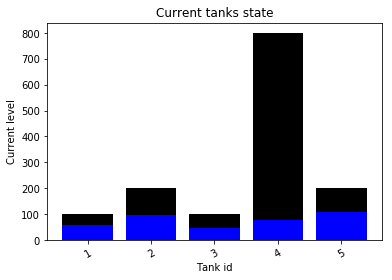

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

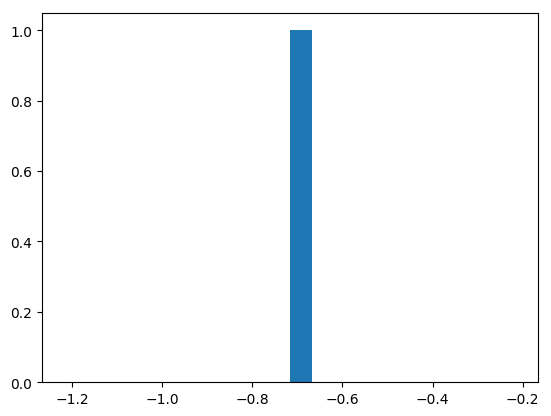

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

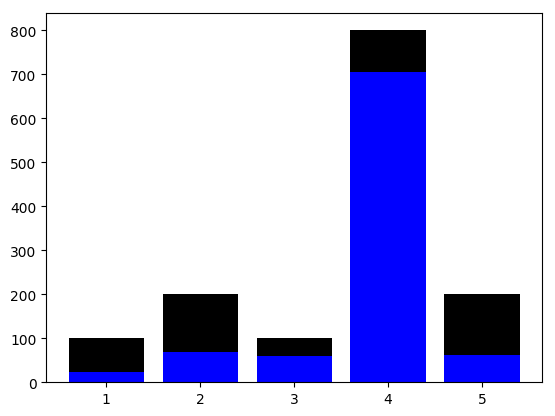

In [15]:
# Visualizing test simulation:

test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())


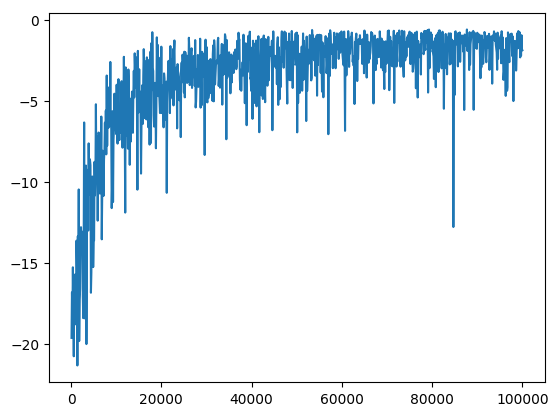

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

plt.plot(discrewards['episode'],discrewards['discreward'], label = "Discounted rewards")

plt.show()
plt.close()


In [17]:
len(list(Q))

27298

In [18]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

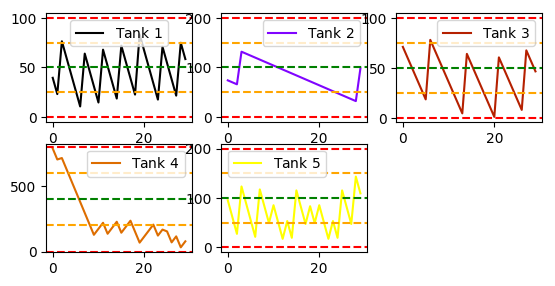

In [19]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

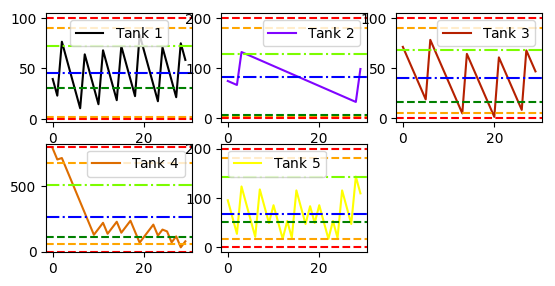

In [20]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')

### Test visualization

In [21]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + f'{simulation_id}' + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [22]:
def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
test_episodes = 1

### Deterministic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.1168656 -0.0006827 0.1161829 0300
Episode 1 t 2 -0.1620157 3.16e-05 0.1620473 1400
Episode 1 t 3 -0.0563087 2.87e-05 0.0563374 4500
Episode 1 t 4 0.0001636 0.0001636 0.0 5500
Episode 1 t 5 -0.1623964 0.0007344 0.1631307 2300
Episode 1 t 6 -0.0115209 3.55e-05 0.0115564 0500
Episode 1 t 7 0.0008252 0.0008252 0.0 5500
Episode 1 t 8 -0.1609367 2.72e-05 0.1609639 3400
Episode 1 t 9 0.0005864 0.0005864 0.0 5500
Episode 1 t 10 -0.1161595 2.34e-05 0.1161829 0400
Episode 1 t 11 -0.1608668 9.71e-05 0.1609639 3300
Episode 1 t 12 -0.1631054 2.53e-05 0.1631307 2300
Episode 1 t 13 0.00045 0.00045 0.0 5500
Episode 1 t 14 -0.1155439 0.0006391 0.1161829 0300
Episode 1 t 15 -0.1609344 2.95e-05 0.1609639 3400
Episode 1 t 16 -0.1609432 2.07e-05 0.1609639 4300
Episode 1 t 17 0.0003097 0.0003097 0.0 5500
Episode 1 t 18 -0.1201882 1.88e-05 0.120207 0200
Episode 1 t 19 -0.1609426 2.13e-05 0.1609639 3300
Episode 1 t 20 0.000741 0.000

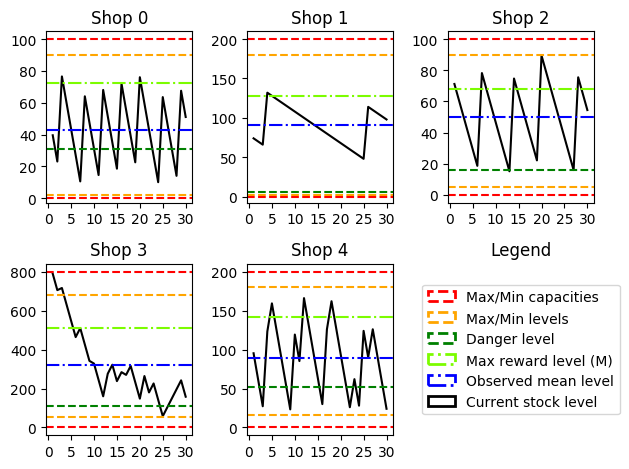

Total discounted rewards Level rewards Transport rewards
-0.7918508597751696 0.007396137580054166 2.8702136939999994
Average trucks sent:  40.0


In [23]:
test_simulation(simulation_id= 16, max_episodes = 100000,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.1168656 -0.0006827 0.1161829 0300
Episode 1 t 2 -0.1649721 1.59e-05 0.164988 4200
Episode 1 t 3 0.0006521 0.0006521 0.0 5500
Episode 1 t 4 -0.056177 0.0001603 0.0563374 4500
Episode 1 t 5 0.0013004 0.0013004 0.0 5500
Episode 1 t 6 -1.1629628 -0.9999868 0.162976 4100
Episode 1 t 7 -0.1156451 0.0005378 0.1161829 0300
Episode 1 t 8 -0.1609493 1.47e-05 0.1609639 4300
Episode 1 t 9 -0.1037878 0.0008387 0.1046265 5300
Episode 1 t 10 -0.1152007 0.0009823 0.1161829 0400
Episode 1 t 11 -0.0584748 2.94e-05 0.0585042 2500
Episode 1 t 12 -0.1609415 2.24e-05 0.1609639 3400
Episode 1 t 13 0.000246 0.000246 0.0 5500
Episode 1 t 14 -0.1161582 2.48e-05 0.1161829 0300
Episode 1 t 15 1.82e-05 1.82e-05 0.0 5500
Episode 1 t 16 -0.1625028 0.0006279 0.1631307 2300
Episode 1 t 17 -0.1608561 0.0001079 0.1609639 4300
Episode 1 t 18 0.0012301 0.0012301 0.0 5500
Episode 1 t 19 -0.1171785 -0.0009956 0.1161829 0400
Episode 1 t 20 -0.16093

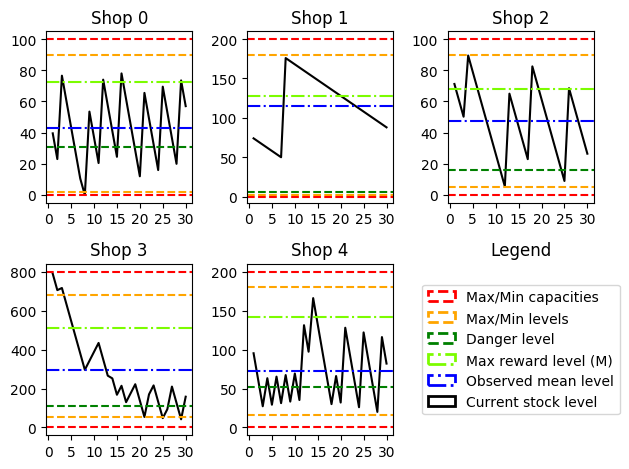

Total discounted rewards Level rewards Transport rewards
-1.3471289419823873 -0.9944471905707256 2.8620107249999998
Average trucks sent:  39.0


In [24]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 -0.0009341 -0.0009341 0.0 5500
Episode 1 t 1 -0.1161544 2.85e-05 0.1161829 0400
Episode 1 t 2 -0.0573836 3.72e-05 0.0574208 1500
Episode 1 t 3 2.83e-05 2.83e-05 0.0 5500
Episode 1 t 4 -0.0561761 0.0001612 0.0563374 4500
Episode 1 t 5 -0.1623987 0.000732 0.1631307 2300
Episode 1 t 6 -0.1161468 3.62e-05 0.1161829 0400
Episode 1 t 7 3.3e-05 3.3e-05 0.0 5500
Episode 1 t 8 2.07e-05 2.07e-05 0.0 5500
Episode 1 t 9 -0.0557557 0.0005816 0.0563374 3500
Episode 1 t 10 -0.1155512 0.0006318 0.1161829 0300
Episode 1 t 11 -0.160875 8.89e-05 0.1609639 4300
Episode 1 t 12 -0.16311 2.07e-05 0.1631307 2400
Episode 1 t 13 -0.1605059 0.0004581 0.1609639 3300
Episode 1 t 14 -0.1161494 3.35e-05 0.1161829 0300
Episode 1 t 15 -0.1046025 2.4e-05 0.1046265 5400
Episode 1 t 16 2.08e-05 2.08e-05 0.0 5500
Episode 1 t 17 -0.1606567 0.0003072 0.1609639 3300
Episode 1 t 18 -0.162255 0.0008757 0.1631307 2300
Episode 1 t 19 -0.1161546 2.83e-05 0.1161829 0400
Episode 1 t 20 2.51e-05 2.51e-0

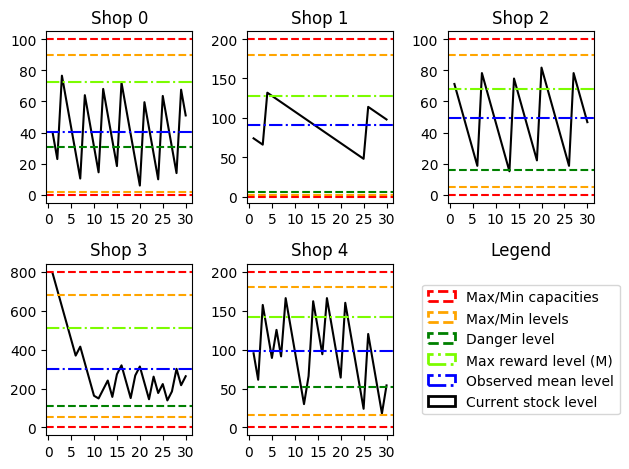

Total discounted rewards Level rewards Transport rewards
-0.7399257680414123 0.006618546339171137 2.924693789999999
Average trucks sent:  41.0


In [25]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes)